In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf

In [2]:
# Загружаем данные
df = pd.read_csv('data/FlightData.csv')

In [3]:
del_columns = ['timestamp', 'time', 'localtime']

# Используйте метод drop для удаления столбцов
df.drop(del_columns, axis=1, inplace=True)


Набор данных состоит из 187654 записей и 7 признаков.

Целевая переменная была вычислена как евклидово расстояние между значениями вертикального и горизонтального отклонения от глиссады.

In [4]:
# объединяем вертикальное и горизонтальное отклонения в один показатель
df['Glidepath deviation'] = np.sqrt(df['Vertical']**2 + df['Horizontal']**2)

#df['Glidepath deviation'] = np.arctan2(df['Vertical'], df['Horizontal'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187654 entries, 0 to 187653
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Roll                   187654 non-null  float64
 1   Pitch                  187654 non-null  float64
 2   Angle                  187654 non-null  float64
 3   Heading                187654 non-null  float64
 4   Altitude               187654 non-null  float64
 5   Vertical               187654 non-null  float64
 6   Horizontal             187654 non-null  float64
 7   Right Sidestick pitch  187654 non-null  float64
 8   Right Sidestick roll   187654 non-null  float64
 9   FPG                    187654 non-null  float64
 10  KGR                    187654 non-null  float64
 11  Glidepath deviation    187654 non-null  float64
dtypes: float64(12)
memory usage: 17.2 MB


In [6]:
# удаляем вертикальное и горизонтальное отклонения, а также ненужные столбцы
columns_to_drop = ["Vertical", "Horizontal","Altitude", "KGR"]  
df.drop(columns=columns_to_drop, inplace=True)

# Собираем датасет

In [7]:
# Разбиваем датасет на X и y
X = df.drop(["Glidepath deviation"], axis=1)
y = df["Glidepath deviation"]


Так как данных много, то для тренировочного набора было взято 85%, а для валидационного и тестового по 7,5%.


In [8]:
# Разбиваем данные на train, test, val.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 0)

Метод масштабирования MinMaxScaler приводит значения признаков к интервалу [0, 1] или другому заданному интервалу. Так как многие признаки изменяются в небольших значениях и находятся в окрестности 0, то использование MinMaxScaler может привести к схожести между loss и val_loss.

Поэтому выбран метод StandardScaler, который центрирует данные (делает их средним равным 0) и масштабирует их так, чтобы стандартное отклонение было равно 1. Это более общий метод масштабирования, который может сохранить более широкий диапазон значений, что может предотвратить схожесть между loss и val_loss.


In [9]:
#scaler = MinMaxScaler()
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [10]:
X_train.shape, X_test.shape, X_val.shape

((159505, 7), (14074, 7), (14075, 7))

# Создаем модель


Функция активации – Relu, которая быстро вычисляется и помогает избежать проблемы исчезающего градиента
.
Используется оптимизатор Nadam. В данной задаче путём обучения модели с разными параметрами, было выяснено, что данный оптимизатор подошёл лучше, чем Adam или SGD. Скорость обучения установлена равной 0.005, количество эпох – 700 (при этих значениях скорости модель ещё сходилась)
. 
В качестве функции потерь выбрана Log-Cosh, так как она подходит для регрессии и менее чувствительна к выбросам, чем MSE.


In [12]:
inputs = tf.keras.layers.Input(shape=X_train.shape[1], name='input')
x_1 = tf.keras.layers.Dense(units=32, activation='relu',  name='dense_1')(inputs)
output = tf.keras.layers.Dense(units=1, activation='relu', name='output') (x_1)

#x_1 = tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='dense_1')(inputs)


model = tf.keras.Model(inputs=inputs, outputs=output)

In [12]:
inputs = tf.keras.layers.Input(shape=X_train.shape[1], name='input')
x_1 = tf.keras.layers.Dense(units=32, activation='relu',  name='dense_1')(inputs)
x_2 = tf.keras.layers.Dense(units=8, activation='relu', name='dense_2')(x_1)
output = tf.keras.layers.Dense(units=1, activation='relu', name='output') (x_2)

model2 = tf.keras.Model(inputs=inputs, outputs=output)

In [45]:
inputs = tf.keras.layers.Input(shape=X_train.shape[1], name='input')
x_1 = tf.keras.layers.Dense(units=32, activation='relu',  name='dense_1')(inputs)
output = tf.keras.layers.Dense(units=1, activation='relu', name='output') (x_1)

#x_1 = tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='dense_1')(inputs)


model3 = tf.keras.Model(inputs=inputs, outputs=output)

In [11]:
inputs = tf.keras.layers.Input(shape=X_train.shape[1], name='input')
#x_1 = tf.keras.layers.Dense(units=32, activation='relu',  name='dense_1')(inputs)
x_1 = tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='dense_1')(inputs)
output = tf.keras.layers.Dense(units=1, activation='relu', name='output') (x_1)

model4 = tf.keras.Model(inputs=inputs, outputs=output)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 7)]               0         
                                                                 
 dense_1 (Dense)             (None, 32)                256       
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 289 (1.13 KB)
Trainable params: 289 (1.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 7)]               0         
                                                                 
 dense_1 (Dense)             (None, 32)                256       
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 529 (2.07 KB)
Trainable params: 529 (2.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 7)]               0         
                                                                 
 dense_1 (Dense)             (None, 32)                256       
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 289 (1.13 KB)
Trainable params: 289 (1.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 7)]               0         
                                                                 
 dense_1 (Dense)             (None, 32)                256       
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 289 (1.13 KB)
Trainable params: 289 (1.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



# Обучение

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.005), 
    loss = tf.keras.losses.LogCosh()
)

In [14]:
model2.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.005), 
    loss = tf.keras.losses.LogCosh()
)

In [65]:
model3.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.005), 
    loss = tf.keras.losses.Huber(delta=3.0)
)

In [21]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=X_train.shape[0],
    epochs=700,
    validation_data=(X_val, y_val),
    shuffle=False,
    steps_per_epoch=1,
    validation_steps=1,
    validation_batch_size=X_val.shape[0]
)

Epoch 1/700
1/1 [==============================] - 1s 1s/step - loss: 0.0038 - val_loss: 0.0056
Epoch 2/700
1/1 [==============================] - 0s 56ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 3/700
1/1 [==============================] - 0s 53ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 4/700
1/1 [==============================] - 0s 75ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 5/700
1/1 [==============================] - 0s 76ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 6/700
1/1 [==============================] - 0s 70ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 7/700
1/1 [==============================] - 0s 70ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 8/700
1/1 [==============================] - 0s 62ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 9/700
1/1 [==============================] - 0s 53ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 10/700
1/1 [==============================] - 0s 54ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 11/700
1/1 [===

In [15]:
history2 = model2.fit(
    x=X_train,
    y=y_train,
    batch_size=X_train.shape[0],
    epochs=700,
    validation_data=(X_val, y_val),
    shuffle=False,
    steps_per_epoch=1,
    validation_steps=1,
    validation_batch_size=X_val.shape[0]
)

Epoch 1/700

1/1 [==============================] - 2s 2s/step - loss: 0.0364 - val_loss: 0.0239
Epoch 2/700
1/1 [==============================] - 0s 64ms/step - loss: 0.0237 - val_loss: 0.0181
Epoch 3/700
1/1 [==============================] - 0s 62ms/step - loss: 0.0180 - val_loss: 0.0142
Epoch 4/700
1/1 [==============================] - 0s 61ms/step - loss: 0.0140 - val_loss: 0.0117
Epoch 5/700
1/1 [==============================] - 0s 59ms/step - loss: 0.0115 - val_loss: 0.0101
Epoch 6/700
1/1 [==============================] - 0s 72ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 7/700
1/1 [==============================] - 0s 63ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 8/700
1/1 [==============================] - 0s 59ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 9/700
1/1 [==============================] - 0s 62ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 10/700
1/1 [==============================] - 0s 58ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 11/700
1/1 [==

In [66]:
history3 = model3.fit(
    x=X_train,
    y=y_train,
    batch_size=X_train.shape[0],
    epochs=700,
    validation_data=(X_val, y_val),
    shuffle=False,
    steps_per_epoch=1,
    validation_steps=1,
    validation_batch_size=X_val.shape[0]
   
)

Epoch 1/700
1/1 [==============================] - 1s 926ms/step - loss: 0.0039 - val_loss: 0.0077
Epoch 2/700
1/1 [==============================] - 0s 54ms/step - loss: 0.0078 - val_loss: 0.0040
Epoch 3/700
1/1 [==============================] - 0s 59ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 4/700
1/1 [==============================] - 0s 54ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 5/700
1/1 [==============================] - 0s 66ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 6/700
1/1 [==============================] - 0s 58ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 7/700
1/1 [==============================] - 0s 55ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 8/700
1/1 [==============================] - 0s 52ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 9/700
1/1 [==============================] - 0s 53ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 10/700
1/1 [==============================] - 0s 52ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 11/700
1/1 [

In [13]:
# Для гипотезы 3
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(256, drop_remainder=True)

# Создайте tf.data.Dataset для валидационных данных
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(256, drop_remainder=True)

# Создайте и скомпилируйте модель
model4.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.005),
    loss=tf.keras.losses.mean_squared_error,
)

# Обучите модель, используя tf.data.Dataset
history4 = model4.fit(
    train_dataset,
    epochs=500,
    validation_data=val_dataset,
    steps_per_epoch=1,
    validation_steps=1
)

Epoch 1/500

1/1 [==============================] - 1s 1s/step - loss: 1.0794 - val_loss: 0.9379
Epoch 2/500
1/1 [==============================] - 0s 20ms/step - loss: 0.7817 - val_loss: 0.8373
Epoch 3/500
1/1 [==============================] - 0s 15ms/step - loss: 0.6214 - val_loss: 0.7522
Epoch 4/500
1/1 [==============================] - 0s 15ms/step - loss: 0.6977 - val_loss: 0.6596
Epoch 5/500
1/1 [==============================] - 0s 14ms/step - loss: 0.5320 - val_loss: 0.5834
Epoch 6/500
1/1 [==============================] - 0s 14ms/step - loss: 0.4432 - val_loss: 0.5141
Epoch 7/500
1/1 [==============================] - 0s 14ms/step - loss: 0.4381 - val_loss: 0.4509
Epoch 8/500
1/1 [==============================] - 0s 15ms/step - loss: 0.5111 - val_loss: 0.3836
Epoch 9/500
1/1 [==============================] - 0s 13ms/step - loss: 0.3521 - val_loss: 0.3337
Epoch 10/500
1/1 [==============================] - 0s 17ms/step - loss: 0.2961 - val_loss: 0.2927
Epoch 11/500
1/1 [==

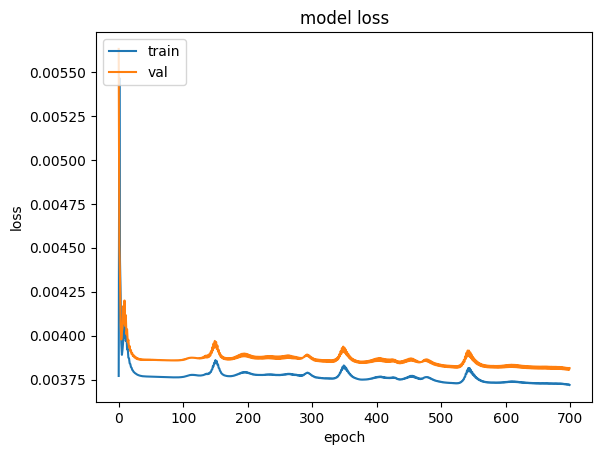

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

***Для графика сверху пояснение***

Ошибка уменьшилась быстро, а потом функции немного колеблются, возможно из-за того, что в датасете содержится много похожих данных.

Модель начинает обучается на шуме и деталях в данных, которые не являются представительными для общего тренда. 

Если в датасете много схожих данных, модель может выучить эти шумы и потерять способность обобщения на новые, ранее не виденные данные.

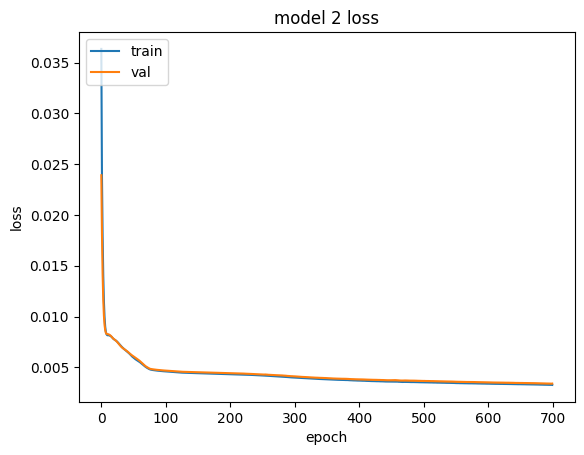

In [16]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

***Для графика сверху пояснение***

Гипотеза 1: увеличение сложности модели улучшит результат.

Добавили второй скрытый слой в архитектуру нейронной сети. 

Функции потерь в данном случае уменьшаются и сильно коррелируют (накладываются друг на друга). Это свидетельствует о том, что либо модель обучилась хорошо, либо очень хорошо «заучила» тренировочные данные. Стоит отметить, что такой хороший результат на новых неизвестных данных модель может не показать. Для этой модели MAE = 0.04764918872152749, что как раз показывает, что на незнакомых данных модель работает не очень хорошо.


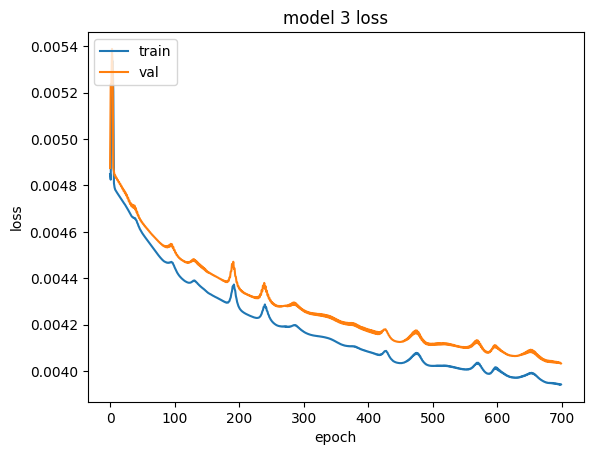

In [61]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model 3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

***Для графика сверху пояснение***

Гипотеза 2: улучшение результата с помощью замены функции потерь на Huber Loss, которая представляет собой компромисс между MSE и MAE. Функция Huber Loss определяется параметром дельта (порог перехода от квадратичной к линейной функции). 

Функции потерь в данном случае начинают постепенно расходиться, что говорит о переобучении (возможно, выбрано слишком большое значение для дельта).

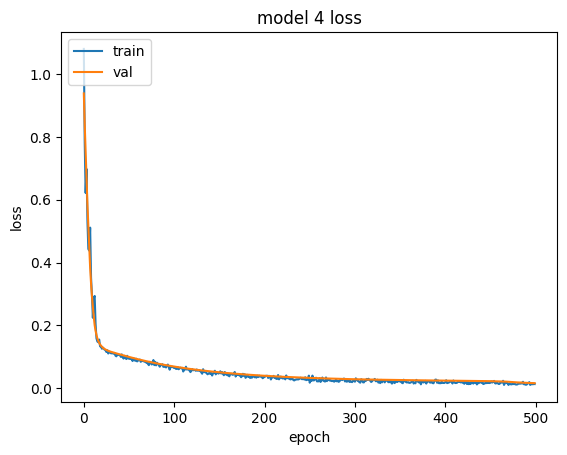

In [14]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model 4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

***Для графика сверху пояснение***

Гипотеза 3: улучшение результата с помощью разделения данных на пакеты (батчи). В методе fit в библиотеке TensorFlow и Keras, параметр batch_size определяет размер пакета. Однако возникли резкие колебания графиков loss и val_loss. Поэтому было использовано drop_remainder=True для гарантии, что размер последнего пакета данных в эпохе будет равен указанному размеру пакета (аналог drop_last=True в PyTorch.). Это может предотвратить использование неполных пакетов данных, что делает обучение более стабильным. 

Функции потерь в данном случае накладываются, а MAE = 0.064. Следовательно, модель хорошо выучила тренировочные данные, а на незнакомых данных показала не очень хороший результат. 

# Оценка

In [24]:
y_pred = model.predict(X_test)

440/440 [==============================] - 0s 950us/step


In [26]:
mae = mean_absolute_error(y_test, y_pred)
print(mae)

0.050944746943429445


In [43]:
# Преобразование массивов в одномерные списки
y_test_list = y_test.tolist()
y_pred_list = y_pred.tolist()

# Создание DataFrame с фактическими и предсказанными значениями
results_df = pd.DataFrame({'Actual': y_test_list, 'Predicted': y_pred_list})

# Вывод нескольких примеров результатов
print("Примеры результатов работы на test датасете:")
print(results_df.head())

Примеры результатов работы на test датасете:
     Actual              Predicted
0  0.043795  [0.03447765111923218]
1  0.168208  [0.14804081618785858]
2  0.036716  [0.02498193085193634]
3  0.325513  [0.09480105340480804]
4  0.086903  [0.03672991693019867]


In [17]:
y_pred2 = model2.predict(X_test)

mae2 = mean_absolute_error(y_test, y_pred2)
print(mae2)

440/440 [==============================] - 1s 946us/step
0.04764918872152749


In [15]:
y_pred4 = model4.predict(X_test)

mae4 = mean_absolute_error(y_test, y_pred4)
print(mae4)

440/440 [==============================] - 0s 922us/step
0.06359520881310633
